<a href="https://colab.research.google.com/github/michaelawe01/Bournemouth-Uni-Data-Science-/blob/main/sainsburys_age_face_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Motivation**

Sainsbury's has a consumer responsibility to ensure that age-restricted products are sold only to individuals who can take responsibility for them.
There is also a legal obligation to avoid selling age-restricted products to younger individuals, as the organization could face fines, which would
negatively impact its reputation. Some examples of age-restricted products include alcohol, tobacco, cigarettes, lighters, fireworks, canned alcoholic beverages (beer, wine, or cider), drugs, volatile substances, and more.

The above premise is the reason why service assistant colleagues at all checkouts request proof of age from anyone who appears to be 25 years old or younger. However, individuals who are 26 years or older still need to wait for a colleague (service assistant) to confirm their age and allow them to purchase age-restricted products. This process can be inconvenient, especially for individuals well over 25 years of age. For instance, why should a 50-year-old man require confirmation from a service assistant to buy pain relievers?

This project aims to address this issue. The face classification model successfully categorizes people into three groups: "under_25," "around_25" (16-25 years old), and "above_25." The project ensures that the system automatically rejects age-restricted purchases by individuals under 16 and allows purchases by individuals above 25. However, individuals aged 16-25 years still need to obtain confirmation from a colleague (service assistant).

Dataset for running and testing this code can be found on https://drive.google.com/drive/folders/1fyyPBHfpvrQ79tD63jdO9OFzFiQzGOEn?usp=drive_link

In [ ]:
#pip install tensorflow #install tensorflow if you dont already have it

# **Importation of Libraries**

In [170]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import os


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

import tarfile

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input, Dense



from keras.callbacks import EarlyStopping
from keras.models import Sequential  # Assuming you have defined the model elsewhere
from keras.api._v2.keras.layers import Dense  # Assuming you have defined the layers in the model

# **Data Extraction**

In [171]:
pip install rarfile #for rar file extraction

In [172]:
# Extract all files in the .rar archive to the current directory
with tarfile.open('UTKFace.tar.gz', 'r:gz') as tar:
    tar.extractall()

import rarfile

# Open the .rar file
#with rarfile.RarFile('UTKFace.rar', 'r') as rf:
    # Extract all files in the .rar archive to the current directory
 #   rf.extractall()

# **Data Preprocessing**

In [173]:
#making a dataframe of our dataset for easy manipulation

dataset_folder = 'UTKFace'  # Update with the actual folder name
full_path = os.path.abspath(dataset_folder)  # Get the full path of the dataset folder

# Create an empty list to store metadata
face_data = []

# Iterate through files in the dataset folder
for file_name in os.listdir(dataset_folder):
    if file_name.endswith('.jpg'):
        # Split the file name
        components = file_name.split('_')

        # Extract age and gender based on known positions
        age = components[0]
        gender = components[1]

        # Additional components can be included in the filename
        # For example: age_gender_ethnicity_filename.jpg
        # ethnicity = components[2] if len(components) > 2 else None

        file_path = os.path.join(full_path, file_name)  # Get the full file path

        face_data.append({'Filename': file_name, 'Age': age, 'Gender': gender, 'FilePath': file_path})

# Create a DataFrame from the metadata list
face_data_df = pd.DataFrame(face_data)

# Display the DataFrame
face_data_df


,Filename,Age,Gender,FilePath
0,32_0_3_20170119162651590.jpg.chip.jpg,32,0,/content/UTKFace/32_0_3_20170119162651590.jpg....
1,85_1_0_20170111205811953.jpg.chip.jpg,85,1,/content/UTKFace/85_1_0_20170111205811953.jpg....
2,50_0_0_20170116192855160.jpg.chip.jpg,50,0,/content/UTKFace/50_0_0_20170116192855160.jpg....
3,50_0_0_20170117001207711.jpg.chip.jpg,50,0,/content/UTKFace/50_0_0_20170117001207711.jpg....
4,25_1_0_20170117141427897.jpg.chip.jpg,25,1,/content/UTKFace/25_1_0_20170117141427897.jpg....
...,...,...,...,...
23703,1_1_0_20170109190843285.jpg.chip.jpg,1,1,/content/UTKFace/1_1_0_20170109190843285.jpg.c...
23704,34_0_1_20170117204703255.jpg.chip.jpg,34,0,/content/UTKFace/34_0_1_20170117204703255.jpg....
23705,2_0_2_20161219212013262.jpg.chip.jpg,2,0,/content/UTKFace/2_0_2_20161219212013262.jpg.c...
23706,68_0_0_20170109015134679.jpg.chip.jpg,68,0,/content/UTKFace/68_0_0_20170109015134679.jpg....


In [174]:
face_data_df['Age'] = face_data_df['Age'].astype(int) #converting age datatype to integer

In [175]:
face_data_df = face_data_df[face_data_df['Age'] <= 70] #reducing the dataset to individuals below 70 years

In [176]:
face_data_df = face_data_df.reset_index(drop=True) #re-indexing of dataframe

In [177]:
#grouping of the target variable
def map_age_to_group(Age):
    if Age > 25:
        return 'above_25'
    elif 16 <= Age <= 25:
        return 'around_25'
    else:
        return 'under_25'

face_data_df['Age_group'] = face_data_df['Age'].apply(map_age_to_group)

# Display the updated DataFrame
face_data_df


,Filename,Age,Gender,FilePath,Age_group
0,32_0_3_20170119162651590.jpg.chip.jpg,32,0,/content/UTKFace/32_0_3_20170119162651590.jpg....,above_25
1,50_0_0_20170116192855160.jpg.chip.jpg,50,0,/content/UTKFace/50_0_0_20170116192855160.jpg....,above_25
2,50_0_0_20170117001207711.jpg.chip.jpg,50,0,/content/UTKFace/50_0_0_20170117001207711.jpg....,above_25
3,25_1_0_20170117141427897.jpg.chip.jpg,25,1,/content/UTKFace/25_1_0_20170117141427897.jpg....,around_25
4,2_0_2_20161219163447671.jpg.chip.jpg,2,0,/content/UTKFace/2_0_2_20161219163447671.jpg.c...,under_25
...,...,...,...,...,...
22478,1_1_0_20170109190843285.jpg.chip.jpg,1,1,/content/UTKFace/1_1_0_20170109190843285.jpg.c...,under_25
22479,34_0_1_20170117204703255.jpg.chip.jpg,34,0,/content/UTKFace/34_0_1_20170117204703255.jpg....,above_25
22480,2_0_2_20161219212013262.jpg.chip.jpg,2,0,/content/UTKFace/2_0_2_20161219212013262.jpg.c...,under_25
22481,68_0_0_20170109015134679.jpg.chip.jpg,68,0,/content/UTKFace/68_0_0_20170109015134679.jpg....,above_25


In [178]:
#to avoid class imbalance, 3000 datasets were choosen randomly for reach class label.

# Create separate DataFrames for each label
above_25_df = face_data_df[face_data_df['Age_group'] == 'above_25']
around_25_df = face_data_df[face_data_df['Age_group'] == 'around_25']
under_25_df = face_data_df[face_data_df['Age_group'] == 'under_25']

# Randomly select 3000 rows from each label's DataFrame
above_25_sample = above_25_df.sample(n=3000, random_state=42)
around_25_sample = around_25_df.sample(n=3000, random_state=42)
under_25_sample = under_25_df.sample(n=3000, random_state=42)

# Concatenate the selected rows to create the final DataFrame
filtered_df = pd.concat([above_25_sample, around_25_sample, under_25_sample], ignore_index=True)

# Shuffle the rows of the final DataFrame
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)
face_data_df = filtered_df
face_data_df


,Filename,Age,Gender,FilePath,Age_group
0,1_0_2_20161219212535950.jpg.chip.jpg,1,0,/content/UTKFace/1_0_2_20161219212535950.jpg.c...,under_25
1,52_0_0_20170111195813450.jpg.chip.jpg,52,0,/content/UTKFace/52_0_0_20170111195813450.jpg....,above_25
2,55_0_0_20170117145731147.jpg.chip.jpg,55,0,/content/UTKFace/55_0_0_20170117145731147.jpg....,above_25
3,25_1_4_20170103235222492.jpg.chip.jpg,25,1,/content/UTKFace/25_1_4_20170103235222492.jpg....,around_25
4,1_1_2_20161219162415934.jpg.chip.jpg,1,1,/content/UTKFace/1_1_2_20161219162415934.jpg.c...,under_25
...,...,...,...,...,...
8995,22_1_4_20170112233752904.jpg.chip.jpg,22,1,/content/UTKFace/22_1_4_20170112233752904.jpg....,around_25
8996,24_0_2_20170116165054448.jpg.chip.jpg,24,0,/content/UTKFace/24_0_2_20170116165054448.jpg....,around_25
8997,22_1_4_20170117145350418.jpg.chip.jpg,22,1,/content/UTKFace/22_1_4_20170117145350418.jpg....,around_25
8998,39_1_0_20170103182037472.jpg.chip.jpg,39,1,/content/UTKFace/39_1_0_20170103182037472.jpg....,above_25


In [179]:
face_data_df.shape #amount of pictures in dataframe

(9000, 5)

In [180]:
#Distribution of the dataset
age_group_counts = face_data_df['Age_group'].value_counts()
print(age_group_counts)

under_25     3000
above_25     3000
around_25    3000
Name: Age_group, dtype: int64


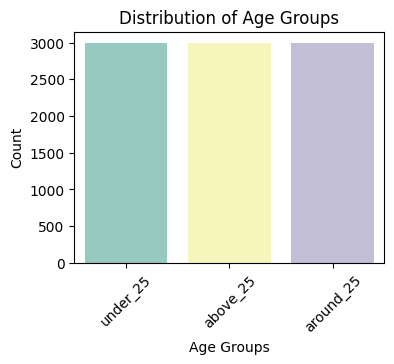

In [181]:
#graphical distribution of the dataset
age_group_counts = face_data_df['Age_group'].value_counts()

# Create a bar plot
plt.figure(figsize=(4, 3))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette="Set3")
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.title('Distribution of Age Groups')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [182]:
#spliting of dataset to test and train dataset

train_df, test_df = train_test_split(face_data_df, train_size=0.7, shuffle =True, random_state=1)

# **creating generators**

In [183]:
def custom_preprocess_input(x):
    x = preprocess_input(x)  # Use the standard preprocess_input first
    # Apply any additional custom preprocessing if needed
    return x

train_generator = ImageDataGenerator(
    preprocessing_function=custom_preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=custom_preprocess_input
)

In [184]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='FilePath',  # Comma was missing after 'x_col'
    y_col='Age_group',
    target_size=(224, 224),
    color_mode='rgb',   # Corrected typo 'colormode' to 'color_mode'
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='FilePath',
    y_col='Age_group',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='FilePath',
    y_col='Age_group',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)


Found 5040 validated image filenames belonging to 3 classes.
Found 1260 validated image filenames belonging to 3 classes.
Found 2700 validated image filenames belonging to 3 classes.


# **Data Modelling**

In [185]:
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',  # Corrected 'weight' to 'weights'
    pooling='avg'
)

pretrained_model.trainable = False  # Corrected 'pretrained_model.translate' to 'pretrained_model.trainable'


In [186]:
pretrained_model.trainable = False

inputs = pretrained_model.inputs
x = Dense(512, activation='relu')(pretrained_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(3, activation='softmax'  # You can adjust the alpha parameter.
)(x)

model = Model(inputs=inputs, outputs=output)  # Corrected 'model = model' to 'model = Model'

print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

# **Model Training**

In [187]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[EarlyStopping(
        monitor='val_loss',  # Corrected 'va_loss' to 'val_loss'
        patience=3,
        restore_best_weights=True  # Corrected 'restore_best_weight' to 'restore_best_weights'
    )]
)


Epoch 1/100
315/315 [==============================] - 18s 46ms/step - loss: 0.7196 - accuracy: 0.6740 - val_loss: 0.6227 - val_accuracy: 0.7238
Epoch 2/100
315/315 [==============================] - 13s 42ms/step - loss: 0.6181 - accuracy: 0.7179 - val_loss: 0.6698 - val_accuracy: 0.7254
Epoch 3/100
315/315 [==============================] - 14s 43ms/step - loss: 0.5668 - accuracy: 0.7405 - val_loss: 0.6053 - val_accuracy: 0.7333
Epoch 4/100
315/315 [==============================] - 16s 49ms/step - loss: 0.5399 - accuracy: 0.7565 - val_loss: 0.5947 - val_accuracy: 0.7325
Epoch 5/100
315/315 [==============================] - 13s 42ms/step - loss: 0.4910 - accuracy: 0.7712 - val_loss: 0.7169 - val_accuracy: 0.6873
Epoch 6/100
315/315 [==============================] - 14s 43ms/step - loss: 0.4614 - accuracy: 0.7968 - val_loss: 0.6289 - val_accuracy: 0.7381
Epoch 7/100
315/315 [==============================] - 13s 42ms/step - loss: 0.4138 - accuracy: 0.8183 - val_loss: 0.6667 - val_ac

# **Results and Evaluations**

In [188]:
results = model.evaluate(test_images, verbose=0)
print("Test accuracy: {: 2f}%".format(results[1]*100))

Test accuracy:  71.222222%


In [197]:
import warnings

# Predictions
predictions = np.argmax(model.predict(test_images), axis=1)

# Confusion Matrix
cm = confusion_matrix(test_images.labels, predictions)

# Classification Report
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    clr = classification_report(test_images.labels, predictions, zero_division=0)

# Display confusion matrix and classification report
print("\nClassification Report:")
print(clr)

print("\nconfusion matrix:")
print(cm)


169/169 [==============================] - 5s 29ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       942
           1       0.59      0.73      0.65       882
           2       0.84      0.83      0.84       876

    accuracy                           0.71      2700
   macro avg       0.72      0.72      0.71      2700
weighted avg       0.72      0.71      0.71      2700


Classification Report:
[[551 339  52]
 [152 641  89]
 [ 38 107 731]]


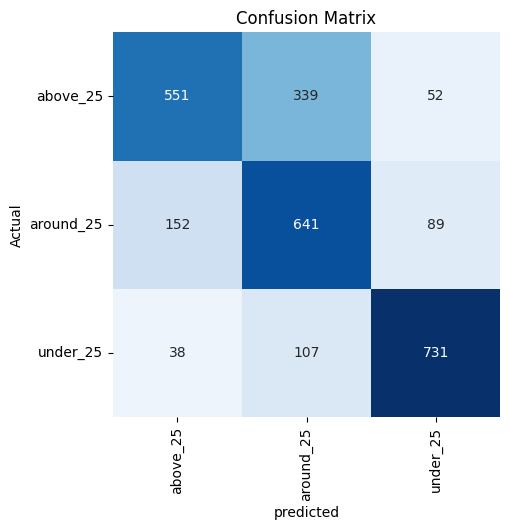

In [190]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
ticks = np.arange(3)  # Define 'ticks' here
plt.xticks(ticks + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **Saving and Deploying Model**

In [191]:
from tensorflow.keras.models import load_model

model.save('my_trained_model.h5')

loaded_model = load_model('my_trained_model.h5')

In [192]:
!pip install streamlit


In [193]:
# Create a Python file, e.g., app.py, and add the following code:

%%writefile agegroup.py
import streamlit as st
from PIL import Image
import io
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import cv2

# Load your pretrained model
model = tf.keras.models.load_model('my_trained_model.h5')

st.set_page_config(layout="centered", page_title="Sainsbury's Face Classification", page_icon="sainsbury's.png", initial_sidebar_state="collapsed")

st.image("sainsburys-01.png")

#st.title("Sainsbury's Face Classification")

# Option to either upload an image or capture from webcam
option = st.radio("Choose an option:", ("Upload Image", "Capture from Webcam"))

if option == "Upload Image":
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])
    if uploaded_file is not None:
        # Display the uploaded image
        img = Image.open(uploaded_file)
        st.image(img, caption='Uploaded Image', use_column_width=True)

        # Preprocess the image for prediction
        img = img.resize((224, 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        img = np.expand_dims(img, axis=0)

        # Make a prediction
        prediction = model.predict(img)
        st.write(f"Prediction: {prediction}")
        class_labels = ["above_25", "around_25", "under_25"]

        # Find the index with the highest probability using argmax
        predicted_class_index = np.argmax(prediction)

        # Map the predicted index to the corresponding label
        predicted_class_label = class_labels[predicted_class_index]



        # Create a Streamlit app
        st.title("Prediction Result")
        st.write("Prediction Probabilities:", prediction)
        st.write("Prediction:", predicted_class_label)

        # Display different messages based on the prediction label
        if predicted_class_label == "above_25":
            st.title("You can now make a purchase.")
        elif predicted_class_label == "around_25":
            st.title("A colleague is coming to assist you.")
        elif predicted_class_label == "under_25":
            st.title("Sorry, you cannot make a purchase for this item.")

elif option == "Capture from Webcam":
    st.write("Webcam not supported")

#st.write("Bye!")


Overwriting agegroup.py


In [194]:
!pip install dash  # For Dash
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
updated 1 package in 1.137s


In [195]:
import urllib.request
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 34.125.214.167


In [198]:
!streamlit run agegroup.py & npx localtunnel --port 8501

[..................] / rollbackFailedOptional: verb npm-session 3137100289a9715


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.214.167:8501

npx: installed 22 in 2.497s
your url is: https://major-sides-worry.loca.lt
1/1 [==============================] - 1s 751ms/step
  Stopping...
^C
